In [1]:
import os
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt

REAL_PATH = "../data_fakenewsnet/raw/politifact/politifact_real.csv"
FAKE_PATH = "../data_fakenewsnet/raw/politifact/politifact_fake.csv"

OUT_DIR = "../outputs/fakenewsnet_text"
os.makedirs(OUT_DIR, exist_ok=True)


In [2]:
real_df = pd.read_csv(REAL_PATH)
fake_df = pd.read_csv(FAKE_PATH)

real_df["label"] = 0
fake_df["label"] = 1

df = pd.concat([real_df, fake_df], ignore_index=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df["label"].value_counts())
df.head()


Shape: (1056, 5)
Columns: ['id', 'news_url', 'title', 'tweet_ids', 'label']
label
0    624
1    432
Name: count, dtype: int64


,id,news_url,title,tweet_ids,label
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...,0
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...,0
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN,0
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN,0
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...,0


In [4]:
def safe_col(df, col):
    return df[col].astype(str) if col in df.columns else ""

# Try common PolitiFact fields (works even if some don’t exist)
title = safe_col(df, "title")
text = safe_col(df, "text")
news_url = safe_col(df, "news_url")

# If dataset uses different naming, also try these:
title2 = safe_col(df, "news_title")
text2  = safe_col(df, "news_text")

raw_text = (title + " " + text + " " + title2 + " " + text2).str.strip()

def clean(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)          # urls
    s = re.sub(r"[^a-z\s]", " ", s)                 # non-letters
    s = re.sub(r"\s+", " ", s).strip()              # extra whitespace
    return s

df["clean_text"] = raw_text.fillna("").apply(clean)

# drop empty
df = df[df["clean_text"].str.len() > 0].copy()

print("After cleaning:", df.shape)
df[["clean_text", "label"]].head()


After cleaning: (1053, 6)


,clean_text,label
0,national federation of independent business,0
1,comments in fayetteville nc,0
2,romney makes pitch hoping to close deal electi...,0
3,democratic leaders say house democrats are uni...,0
4,budget of the united states government fy,0


In [6]:
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=50000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7914691943127962
              precision    recall  f1-score   support

           0      0.765     0.936     0.842       125
           1      0.862     0.581     0.694        86

    accuracy                          0.791       211
   macro avg      0.813     0.759     0.768       211
weighted avg      0.804     0.791     0.782       211

Confusion matrix:
 [[117   8]
 [ 36  50]]


In [7]:
y_proba = model.predict_proba(X_test)[:, 1]

def eval_threshold(thresh: float):
    y_pred_t = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    return {
        "threshold": thresh,
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)
results = pd.DataFrame([eval_threshold(t) for t in thresholds])

results.to_csv(os.path.join(OUT_DIR, "threshold_results.csv"), index=False)
results


,threshold,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.1,0.407583,0.407583,1.000000,0.579125,86,125,0,0
1,0.2,0.488152,0.443299,1.000000,0.614286,86,108,17,0
2,0.3,0.649289,0.537500,1.000000,0.699187,86,74,51,0
3,0.4,0.824645,0.720721,0.930233,0.812183,80,31,94,6
4,0.5,0.791469,0.862069,0.581395,0.694444,50,8,117,36
5,0.6,0.715640,0.964286,0.313953,0.473684,27,1,124,59
6,0.7,0.625592,1.000000,0.081395,0.150538,7,0,125,79
7,0.8,0.592417,0.000000,0.000000,0.000000,0,0,125,86
8,0.9,0.592417,0.000000,0.000000,0.000000,0,0,125,86


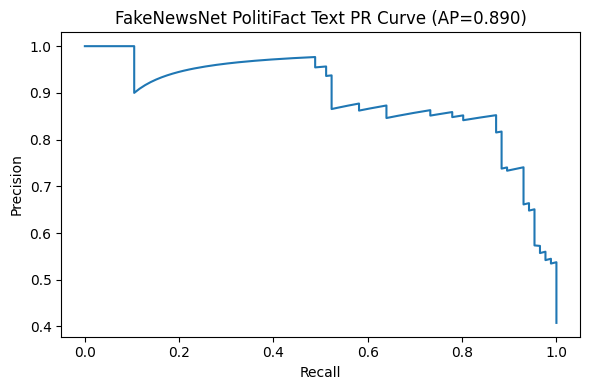

Average Precision (AP): 0.889552687595217


In [8]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"FakeNewsNet PolitiFact Text PR Curve (AP={ap:.3f})")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pr_curve.png"), dpi=200)
plt.show()

print("Average Precision (AP):", ap)


In [9]:
PROC_PATH = "../data_fakenewsnet/processed/politifact_text_processed.csv"
os.makedirs("../data_fakenewsnet/processed", exist_ok=True)

keep_cols = ["clean_text", "label"]
df[keep_cols].to_csv(PROC_PATH, index=False)
print("Saved:", PROC_PATH)


Saved: ../data_fakenewsnet/processed/politifact_text_processed.csv
